## Spatial Modeling and Analytics
### Exploration
# A Simple Site Selection Example

## Reminder
<a href="#/slide-2-0" class="navigate-right" style="background-color:blue;color:white;padding:8px;margin:2px;font-weight:bold;">Continue with the lesson</a>

<br>
</br>
<font size="+1">

By continuing with this lesson you are granting your permission to take part in this research study for the Hour of Cyberinfrastructure: Developing Cyber Literacy for GIScience project. In this study, you will be learning about cyberinfrastructure and related concepts using a web-based platform that will take approximately one hour per lesson. Participation in this study is voluntary.

Participants in this research must be 18 years or older. If you are under the age of 18 then please exit this webpage or navigate to another website such as the Hour of Code at https://hourofcode.com, which is designed for K-12 students.

If you are not interested in participating please exit the browser or navigate to this website: http://www.umn.edu. Your participation is voluntary and you are free to stop the lesson at any time.

For the full description please navigate to this website: <a href="../../gateway-lesson/gateway/gateway-1.ipynb">Gateway Lesson Research Study Permission</a>.

</font>

In [1]:
# This code cell starts the necessary setup for Hour of CI lesson notebooks.
# First, it enables users to hide and unhide code by producing a 'Toggle raw code' button below.
# Second, it imports the hourofci package, which is necessary for lessons and interactive Jupyter Widgets.
# Third, it helps hide/control other aspects of Jupyter Notebooks to improve the user experience
# This is an initialization cell
# It is not displayed because the Slide Type is 'Skip'

from IPython.display import HTML, IFrame, Javascript, display
from ipywidgets import interactive
import ipywidgets as widgets
from ipywidgets import Layout

import getpass # This library allows us to get the username (User agent string)

# import package for hourofci project  '../../supplementary'
import sys
sys.path.append('../../supplementary') # relative path (may change depending on the location of the lesson notebook)

import hourofci

import warnings
warnings.filterwarnings('ignore') # Hide warnings

# load javascript to initialize/hide cells, get user agent string, and hide output indicator
# hide code by introducing a toggle button "Toggle raw code"
HTML(''' 
    <script type="text/javascript" src=\"../../supplementary/js/custom.js\"></script>
    
    <input id="toggle_code" type="button" value="Toggle raw code">
''')



# Let's Create a Basic Site Suitability Model

## Goal: 
Find buildings in a city that are suitable candidates for a new coffee shop business.

## Criteria:
The candidate buildings should be:
1. A building type of commercial, retail, or office building
1. At least 400 meters from other coffee shops
1. Close to a bikepath
1. Close to a cinema

## The process:
1. Determine the criteria (done!)
1. Get data
1. Create buffers
1. Assign weights
1. Intersect and sum values

The result is a map showing the site suitability values. Suitability is indicated by the value - high values are highly suitable. 

# Get the data
First, as usual, we need to import the appropriate python packages, with `osmnx` being the most important one since this is where our data come from.

In [2]:
from IPython import get_ipython
import osmnx as ox 
import pandas as pd
import geopandas as gpd
import folium
import matplotlib.pyplot as plt
get_ipython().run_line_magic('matplotlib', 'inline')
#Tells jupyter to plot matplotlib figures inline


Since we're going to call for Minneapolis repeatedly, let's set a variable to store our location. 

[In OSM, you can use standard place names. If you want to run this notebook later for a different place, you can simply put a new placename in here. Remember that since OSM is crowd-sourced, you might not find all the places you want to use in the dataset. However, all major US and global cities are probably there.] 

In [3]:
place = 'Minneapolis, MN'
place

'Minneapolis, MN'

Our criteria require that we get data about coffee shops, bikepaths, cinemas and buildings. The OSM data contains all these kinds of data, but we have to extract each one separately for our model.

In this first block, we'll get cafes whose cuisine is coffee shop in Minneapolis, Minnesota. 
We use osmnx to create a gdf (GeoDataFrame) which is stored in the `coffee_shops` variable.

In [4]:
tags = {'amenity':'cafe', 'cuisine':'coffee-shop'}  
coffee_shops = ox.geometries_from_place(place, tags) 

# Convert to UTM
coffee_shops = coffee_shops.to_crs('epsg:3174') 

coffee_shops.info()
coffee_shops.head()

<class 'geopandas.geodataframe.GeoDataFrame'>
MultiIndex: 141 entries, ('node', 319434041) to ('way', 988165776)
Data columns (total 62 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   amenity                141 non-null    object  
 1   cuisine                95 non-null     object  
 2   name                   139 non-null    object  
 3   geometry               141 non-null    geometry
 4   addr:city              73 non-null     object  
 5   addr:country           3 non-null      object  
 6   addr:housenumber       89 non-null     object  
 7   addr:postcode          75 non-null     object  
 8   addr:state             62 non-null     object  
 9   addr:street            91 non-null     object  
 10  atm                    2 non-null      object  
 11  drive_through          5 non-null      object  
 12  internet_access        35 non-null     object  
 13  opening_hours          49 non-null     object  
 14  o

amenity           cuisine               name  \
element_type osmid                                                    
node         319434041    cafe       coffee_shop      Corner Coffee   
             343298976    cafe  coffee_shop;cafe  Purple Onion Café   
             478479502    cafe               NaN          Dunn Bros   
             478479503    cafe       coffee_shop      Milkweed Cafe   
             562529853    cafe               NaN       May Day Cafe   

                                             geometry    addr:city  \
element_type osmid                                                   
node         319434041  POINT (306971.389 973129.746)          NaN   
             343298976  POINT (309932.629 972175.204)  Minneapolis   
             478479502  POINT (312011.719 968409.911)          NaN   
             478479503  POINT (311178.510 968499.451)  Minneapolis   
             562529853  POINT (308261.932 967850.146)          NaN   

                       addr:country addr:housenumber addr:postcode addr:state  \
element_type osmid                                                              
node         319434041          NaN              NaN           NaN        NaN   
             343298976           US             1301         55414         MN   
             478479502          NaN              NaN           NaN        NaN   
             478479503          NaN             3822         55406         MN   
             562529853          NaN             3440           NaN        NaN   

                                        addr:street  ... building note  \
element_type osmid                                   ...                 
node         319434041                          NaN  ...      NaN  NaN   
             343298976  Southeast University Avenue  ...      NaN  NaN   
             478479502                          NaN  ...      NaN  NaN   
             478479503             East Lake Street  ...      NaN  NaN   
             562529853     Bloomington Avenue South  ...      NaN  NaN   

                       start_date building:levels shop was:name roof:levels  \
element_type osmid                                                            
node         319434041        NaN             NaN  NaN      NaN         NaN   
             343298976        NaN             NaN  NaN      NaN         NaN   
             478479502        NaN             NaN  NaN      NaN         NaN   
             478479503        NaN             NaN  NaN      NaN         NaN   
             562529853        NaN             NaN  NaN      NaN         NaN   

                       addr:unit  ref room  
element_type osmid                          
node         319434041       NaN  NaN  NaN  
             343298976       NaN  NaN  NaN  
             478479502       NaN  NaN  NaN  
             478479503       NaN  NaN  NaN  
             562529853       NaN  NaN  NaN  

[5 rows x 62 columns]

We got 140 coffee shops, did you? 

And what does this look like?

<AxesSubplot:>

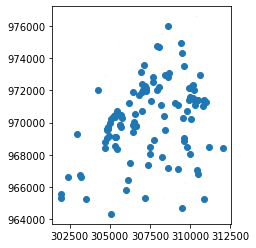

In [5]:
coffee_shops.plot()

Next we'll get the bikepaths. Since OSM is crowd-sourced, the tagging of features is often inconsistent. Sometimes you need to use more than one tag to find all the features you are looking for. Here we're using three. 

[If you want to know more about OSM tags for mapped features, see https://wiki.openstreetmap.org/wiki/Map_features.] 

/opt/tljh/user/lib/python3.7/site-packages/osmnx/utils_geo.py:335: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for polygon in geometry:
/opt/tljh/user/lib/python3.7/site-packages/osmnx/utils_geo.py:426: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:


<class 'geopandas.geodataframe.GeoDataFrame'>
MultiIndex: 1783 entries, ('way', 5994268) to ('relation', 2338573)
Columns: 116 entries, highway to type
dtypes: geometry(1), object(115)
memory usage: 1.7+ MB


highway railway  \
element_type osmid                          
way          5994268  residential     NaN   
             5994905  residential     NaN   
             5995651     cycleway     NaN   
             5996341     cycleway     NaN   
             5997178  residential     NaN   

                                                               geometry  \
element_type osmid                                                        
way          5994268  LINESTRING (306473.343 966997.567, 306479.160 ...   
             5994905  LINESTRING (308896.861 971273.132, 308890.873 ...   
             5995651  LINESTRING (302737.884 971283.404, 302737.712 ...   
             5996341  LINESTRING (306480.856 972425.075, 306485.968 ...   
             5997178  LINESTRING (309754.279 976704.619, 309777.423 ...   

                     crossing     bicycle foot horse motor_vehicle source  \
element_type osmid                                                          
way          5994268      NaN  designated  NaN   NaN   destination    NaN   
             5994905      NaN         NaN  NaN   NaN           NaN    NaN   
             5995651      NaN         NaN  yes   NaN           NaN    NaN   
             5996341      NaN         NaN  yes   NaN           NaN    NaN   
             5997178      NaN  designated  NaN   NaN           NaN    NaN   

                     note  ... mtb:scale:uphill sac_scale trail_visibility  \
element_type osmid         ...                                               
way          5994268  NaN  ...              NaN       NaN              NaN   
             5994905  NaN  ...              NaN       NaN              NaN   
             5995651  NaN  ...              NaN       NaN              NaN   
             5996341  NaN  ...              NaN       NaN              NaN   
             5997178  NaN  ...              NaN       NaN              NaN   

                     busway motorcar old_name_1 oneway:foot lanes:bus ways  \
element_type osmid                                                           
way          5994268    NaN      NaN        NaN         NaN       NaN  NaN   
             5994905    NaN      NaN        NaN         NaN       NaN  NaN   
             5995651    NaN      NaN        NaN         NaN       NaN  NaN   
             5996341    NaN      NaN        NaN         NaN       NaN  NaN   
             5997178    NaN      NaN        NaN         NaN       NaN  NaN   

                     type  
element_type osmid         
way          5994268  NaN  
             5994905  NaN  
             5995651  NaN  
             5996341  NaN  
             5997178  NaN  

[5 rows x 116 columns]

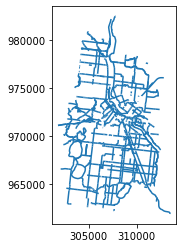

In [6]:
tags = {'highway':'cycleway','route':'bicycle','cycleway':True}
bikepaths = ox.geometries_from_place(place, tags)
bikepaths = bikepaths.to_crs('epsg:3174') 
bikepaths.info()
bikepaths.plot()
bikepaths.head()

Now get the cinema point features.

/opt/tljh/user/lib/python3.7/site-packages/osmnx/utils_geo.py:335: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for polygon in geometry:
/opt/tljh/user/lib/python3.7/site-packages/osmnx/utils_geo.py:426: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:


<class 'geopandas.geodataframe.GeoDataFrame'>
MultiIndex: 7 entries, ('node', 544194079) to ('way', 275333467)
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   addr:housenumber        7 non-null      object  
 1   addr:street             7 non-null      object  
 2   amenity                 7 non-null      object  
 3   name                    7 non-null      object  
 4   wikidata                6 non-null      object  
 5   geometry                7 non-null      geometry
 6   addr:city               5 non-null      object  
 7   addr:postcode           5 non-null      object  
 8   addr:state              3 non-null      object  
 9   website                 4 non-null      object  
 10  phone                   1 non-null      object  
 11  wheelchair              1 non-null      object  
 12  wheelchair:description  1 non-null      object  
 13  nodes                   2 non-null      o

addr:housenumber                  addr:street amenity  \
element_type osmid                                                              
node         544194079              1320                Lagoon Avenue  cinema   
             544194087              2906        Hennepin Avenue South  cinema   
             1077152679              115        Southeast Main Street  cinema   
             2276471606             3258             Minnehaha Avenue  cinema   
             6410470512              300  Southeast Washington Avenue  cinema   
way          61133375               3800            42nd Avenue South  cinema   
             275333467              4814         Chicago Avenue South  cinema   

                                                   name   wikidata  \
element_type osmid                                                   
node         544194079                    Lagoon Cinema  Q42815500   
             544194087                   Uptown Theatre   Q7899454   
             1077152679        St. Anthony Main Theatre  Q42815550   
             2276471606              Trylon Microcinema  Q22060358   
             6410470512  Coffman Memorial Union Theater        NaN   
way          61133375                 Riverview Theater  Q17287169   
             275333467                  Parkway Theater  Q42815271   

                                                                  geometry  \
element_type osmid                                                           
node         544194079                       POINT (304930.757 969286.396)   
             544194087                       POINT (304782.732 969259.691)   
             1077152679                      POINT (308575.832 972835.241)   
             2276471606                      POINT (310010.895 968038.388)   
             6410470512                      POINT (310035.771 971332.267)   
way          61133375    POLYGON ((311267.972 966881.111, 311304.954 96...   
             275333467   POLYGON ((307171.947 965258.050, 307162.821 96...   

                           addr:city addr:postcode addr:state  \
element_type osmid                                              
node         544194079           NaN           NaN        NaN   
             544194087   Minneapolis         55408         MN   
             1077152679          NaN           NaN        NaN   
             2276471606  Minneapolis         55406        NaN   
             6410470512  Minneapolis         55455         MN   
way          61133375    Minneapolis         55405        NaN   
             275333467   Minneapolis         55417         MN   

                                                     website            phone  \
element_type osmid                                                              
node         544194079                                   NaN              NaN   
             544194087      https://www.landmarktheatres.com              NaN   
             1077152679  http://www.stanthonymaintheatre.com  +1-612-331-4724   
             2276471606                   http://take-up.org              NaN   
             6410470512                                  NaN              NaN   
way          61133375        http://www.riverviewtheater.com              NaN   
             275333467                                   NaN              NaN   

                        wheelchair  \
element_type osmid                   
node         544194079         NaN   
             544194087         NaN   
             1077152679        yes   
             2276471606        NaN   
             6410470512        NaN   
way          61133375          NaN   
             275333467         NaN   

                                                    wheelchair:description  \
element_type osmid                                                           
node         544194079                                                 NaN   
             544194087                                             

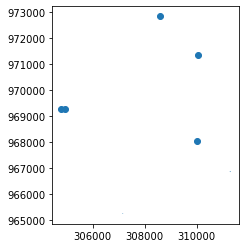

In [7]:
tags = {'amenity':'cinema'} 
cinemas = ox.geometries_from_place(place, tags)
cinemas = cinemas.to_crs('epsg:3174') 
cinemas.info()
cinemas.plot()
cinemas

Finally fetch the footprints (outlines, i.e. polygons) for commerical, retail and office buildings in Minneapolis. This may take some time, so be patient while waiting for the asterisk to change to a number. 

/opt/tljh/user/lib/python3.7/site-packages/osmnx/utils_geo.py:335: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for polygon in geometry:
/opt/tljh/user/lib/python3.7/site-packages/osmnx/utils_geo.py:426: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:


<class 'geopandas.geodataframe.GeoDataFrame'>
MultiIndex: 355 entries, ('node', 5646457667) to ('relation', 4009806)
Data columns (total 96 columns):
 #   Column                       Non-Null Count  Dtype   
---  ------                       --------------  -----   
 0   geometry                     355 non-null    geometry
 1   addr:city                    129 non-null    object  
 2   addr:housenumber             183 non-null    object  
 3   addr:postcode                142 non-null    object  
 4   addr:street                  175 non-null    object  
 5   amenity                      35 non-null     object  
 6   craft                        1 non-null      object  
 7   email                        1 non-null      object  
 8   name                         127 non-null    object  
 9   opening_hours                24 non-null     object  
 10  phone                        32 non-null     object  
 11  website                      44 non-null     object  
 12  wheelchair         

geometry  \
element_type osmid                                                           
node         5646457667                      POINT (307257.633 972182.875)   
way          27346712    POLYGON ((306968.964 972339.489, 306955.665 97...   
             27346744    POLYGON ((307732.339 971788.138, 307792.045 97...   
             29060521    POLYGON ((306944.067 972531.328, 307007.518 97...   
             29079932    POLYGON ((310767.195 965213.725, 310775.794 96...   

                           addr:city addr:housenumber addr:postcode  \
element_type osmid                                                    
node         5646457667  Minneapolis              651         55402   
way          27346712            NaN              NaN           NaN   
             27346744            NaN              NaN           NaN   
             29060521            NaN              NaN           NaN   
             29079932            NaN             4605         55406   

                           addr:street    amenity craft email  \
element_type osmid                                              
node         5646457667  Nicollet Mall        NaN   NaN   NaN   
way          27346712              NaN        NaN   NaN   NaN   
             27346744              NaN        NaN   NaN   NaN   
             29060521              NaN        NaN   NaN   NaN   
             29079932     Hiawatha Ave  fast_food   NaN   NaN   

                                            name  \
element_type osmid                                 
node         5646457667  Dayton at Gaviidae YMCA   
way          27346712         Mayo Clinic Square   
             27346744                        NaN   
             29060521              Butler Square   
             29079932                Burger King   

                                                opening_hours  ... distillery  \
element_type osmid                                             ...              
node         5646457667  Mo-Fr 05:00-22:00, Sa-Su 07:00-20:00  ...        NaN   
way          27346712                                     NaN  ...        NaN   
             27346744                                     NaN  ...        NaN   
             29060521                                     NaN  ...        NaN   
             29079932       Mo-Fr 6:00-23:00; Sa-Su 6:00-1:00  ...        NaN   

                        landuse building:vacant dispensing healthcare female  \
element_type osmid                                                             
node         5646457667     NaN             NaN        NaN        NaN    NaN   
way          27346712       NaN             NaN        NaN        NaN    NaN   
             27346744       NaN             NaN        NaN        NaN    NaN   
             29060521       NaN             NaN        NaN        NaN    NaN   
             29079932       NaN             NaN        NaN        NaN    NaN   

                        male smoking ways type  
element_type osmid                              
node         5646457667  NaN     NaN  NaN  NaN  
way          27346712    NaN     NaN  NaN  NaN  
             27346744    NaN     NaN  NaN  NaN  
             29060521    NaN     NaN  NaN  NaN  
             29079932    NaN     NaN  NaN  NaN  

[5 rows x 96 columns]

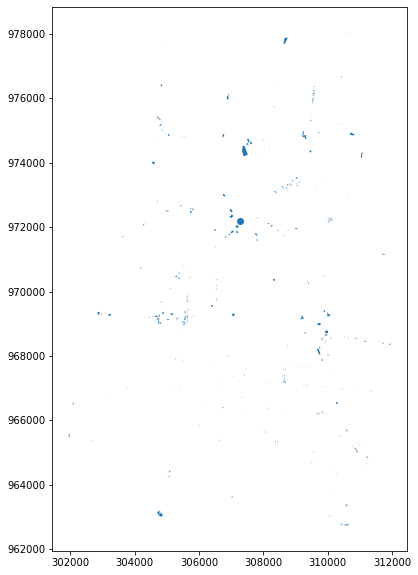

In [8]:
tags = {'building':['commercial','retail','offices']}
buildings = ox.geometries_from_place(place, tags)
buildings = buildings.to_crs('epsg:3174') 
buildings.info()
buildings.plot(figsize = (20,10))
buildings.head()

Now, we have all our data. Let's go back to the criteria so we can see how we need to manipulate these data.

Recall that the candidate buildings should be:

1. A building type of commercial, retail, or office building
1. At least 400 meters from other coffee shops
1. Close to a bikepath
1. Close to a cinema

OK, we've already taken care of criteria #1 by getting data about only buildings of these types. To do criteria #2 we need to create buffers...

## Create buffers

Buffers are used to define the area of influence of features. We'll buffer the coffee shops by 400m as an exclusion zone in which we don't want to select candidate sites. 

<AxesSubplot:>

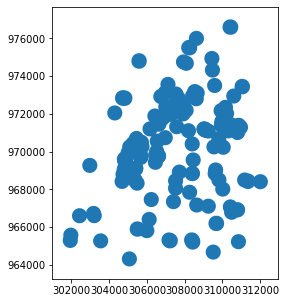

In [9]:
coffee_shops_buffer = gpd.GeoDataFrame(coffee_shops.buffer(400), geometry = coffee_shops.buffer(400))
coffee_shops_buffer.plot(figsize = (5,5))

Good. This plot shows all those areas that are within 400m buffer of existing coffee shops. We do not want to include buildings in these areas in our result. 

Now we need to deal with the final two criteria in which locations close to cinemas and bikepaths are more favorable than those that are farther away. Thus places nearby should have higher value in our site selection than places far away - we do this by assigning weights.

## Assign weights

There are many ways to assign weights in site suitability models. Since this is all vector data, we're going to assign weights by creating concentric buffers with declining value as distance from the feature increases. For example, we prefer places that are close to cinemas, so locations that are less than 500 m get a higher weight than places between 500 and 1000 m, and those get more than places 1000 to 1500m away. Anything futher than 1500 gets no weight at all! 

Let's see how this works with our Cinema data.

0  \
0  POLYGON ((305930.757 969286.396, 305925.942 96...   
1  POLYGON ((305782.732 969259.691, 305777.916 96...   
2  POLYGON ((309575.832 972835.241, 309571.017 97...   
3  POLYGON ((311010.895 968038.388, 311006.079 96...   
4  POLYGON ((311035.771 971332.267, 311030.956 97...   
5  POLYGON ((310275.826 967006.194, 310292.636 96...   
6  POLYGON ((307455.388 966216.715, 307462.233 96...   

                                            geometry  weight  
0  POLYGON ((305911.543 969091.305, 305887.698 96...       2  
1  POLYGON ((305763.517 969064.601, 305739.672 96...       2  
2  POLYGON ((309571.017 972737.224, 309556.617 97...       2  
3  POLYGON ((311006.079 967940.371, 310991.680 96...       2  
4  POLYGON ((311030.956 971234.249, 311016.557 97...       2  
5  POLYGON ((310292.636 967101.835, 310318.643 96...       2  
6  POLYGON ((307462.233 966214.990, 307552.171 96...       2

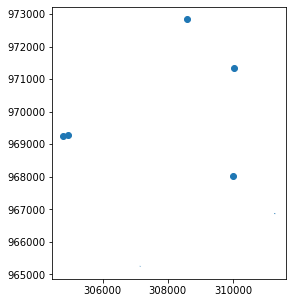

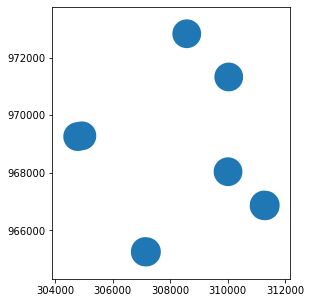

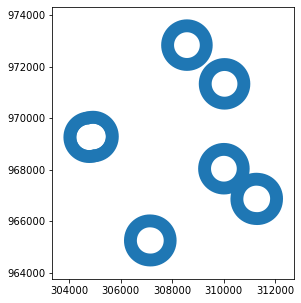

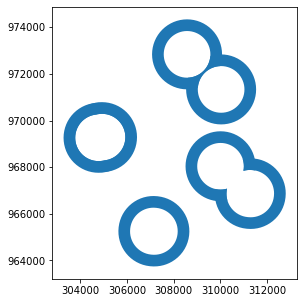

In [10]:
# Cinema weighting
cinema_df1 = gpd.GeoDataFrame(cinemas.buffer(1500), geometry = cinemas.buffer(1500))
cinema_df2 = gpd.GeoDataFrame(cinemas.buffer(1000), geometry = cinemas.buffer(1000))
cinema_df3 = gpd.GeoDataFrame(cinemas.buffer(500), geometry = cinemas.buffer(500))

cinema3 = cinema_df3
cinema3['weight'] = 3

cinema2 = gpd.overlay(cinema_df2, cinema_df3, how='difference')
cinema2['weight'] = 2

cinema1 = gpd.overlay(cinema_df1, cinema_df2, how='difference')
cinema1['weight'] = 1

cinemas.plot(figsize = (5,5))
cinema3.plot(figsize = (5,5))
cinema2.plot(figsize = (5,5))
cinema1.plot(figsize = (5,5))

cinema2

Note how the buffers nest inside of each other. Weights are 3 for the smallest, 2 for the middle one and 1 for the largest/furthest away. 

MOHSEN - why do this this way. Why not just stick all the data together sequentially?

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: `keep_geom_type=True` in overlay resulted in 13 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  """Entry point for launching an IPython kernel.
/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: `keep_geom_type=True` in overlay resulted in 9 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  


0_1  weight_1  \
0   POLYGON ((306430.757 969286.396, 306423.534 96...       1.0   
1   POLYGON ((306282.732 969259.691, 306275.509 96...       1.0   
2   POLYGON ((310075.832 972835.241, 310068.609 97...       1.0   
3   POLYGON ((311510.895 968038.388, 311503.672 96...       1.0   
4   POLYGON ((311535.771 971332.267, 311528.549 97...       1.0   
5   POLYGON ((309779.753 967068.735, 309804.968 96...       1.0   
6   POLYGON ((307553.695 966706.983, 307607.376 96...       1.0   
7                                                None       NaN   
8                                                None       NaN   
9                                                None       NaN   
10                                               None       NaN   
11                                               None       NaN   
12                                               None       NaN   
13                                               None       NaN   
14                                               None       NaN   
15                                               None       NaN   
16                                               None       NaN   
17                                               None       NaN   
18                                               None       NaN   
19                                               None       NaN   
20                                               None       NaN   

                                                  0_2  weight_2  \
0                                                None       NaN   
1                                                None       NaN   
2                                                None       NaN   
3                                                None       NaN   
4                                                None       NaN   
5                                                None       NaN   
6                                                None       NaN   
7   POLYGON ((305930.757 969286.396, 305925.942 96...       2.0   
8   POLYGON ((305782.732 969259.691, 305777.916 96...       2.0   
9   POLYGON ((309575.832 972835.241, 309571.017 97...       2.0   
10  POLYGON ((311010.895 968038.388, 311006.079 96...       2.0   
11  POLYGON ((311035.771 971332.267, 311030.956 97...       2.0   
12  POLYGON ((310275.826 967006.194, 310292.636 96...       2.0   
13  POLYGON ((307455.388 966216.715, 307462.233 96...       2.0   
14                                               None       NaN   
15                                               None       NaN   
16                                               None       NaN   
17                                               None       NaN   
18                                               None       NaN   
19                                               None       NaN   
20                                               None       NaN   

                                                    0  weight  \
0                                                None     NaN   
1                                                None     NaN   
2                                                None     NaN   
3                                                None     NaN   
4                                                None     NaN   
5                                                None     NaN   
6                                                None     NaN   
7                                                None     NaN   
8                                                None     NaN   
9                                                None     NaN   
10                                               None     NaN   
11                                               None     NaN   
12                                               None     NaN   
13                                               None     NaN   
14  POLYGON ((305430.757 969286.396, 305428.350 96...     3.0   
15  POLYGON ((305282.732 969259.691, 305280.324 96...     3.

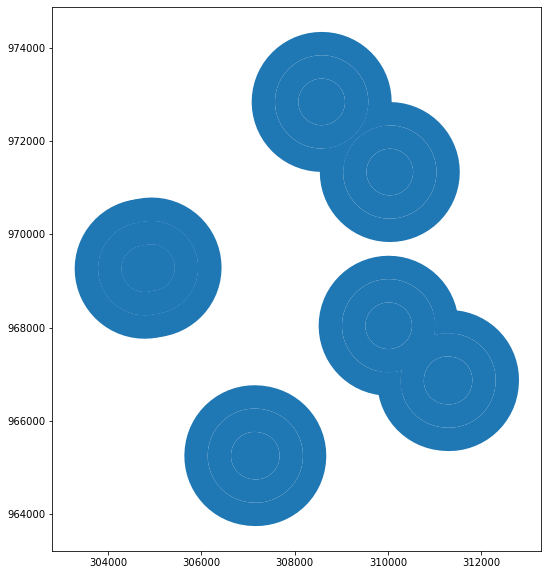

In [11]:
cinema_w = gpd.overlay(cinema1, cinema2, how='union')
cinema_w = gpd.overlay(cinema_w, cinema3, how='union')
cinema_w.plot(figsize = (10,10))

cinema_w['weights'] = pd.concat([cinema_w['weight_1'].fillna(0).astype('int'), 
                                 cinema_w['weight_2'].fillna(0).astype('int'), 
                                 cinema_w['weight'].fillna(0).astype('int')], axis = 1).max(axis=1)

cinema_w

Now we assign weights to the bikepaths. We'll set only 2 weights - 2 for locations less than 15100 m away and 1 for locations between 150 to 300m. 

<AxesSubplot:>

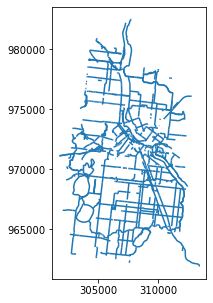

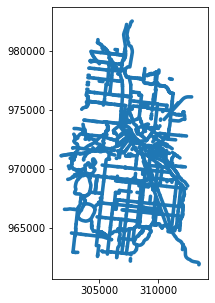

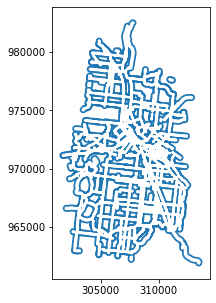

In [12]:
bikepaths_df2 = gpd.GeoDataFrame(bikepaths.buffer(150), geometry = bikepaths.buffer(150))
bikepaths_df1 = gpd.GeoDataFrame(bikepaths.buffer(300), geometry = bikepaths.buffer(300))

bikepaths2 = bikepaths_df2
bikepaths2['weight'] = 2

bikepaths1 = gpd.overlay(bikepaths_df1, bikepaths_df2, how='difference')
bikepaths1['weight'] = 1

bikepaths.plot(figsize = (5,5))
bikepaths2.plot(figsize = (5,5))
bikepaths1.plot(figsize = (5,5))

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: `keep_geom_type=True` in overlay resulted in 7984 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  del sys.path[0]


0_1  weight_1  \
0     POLYGON ((306595.574 969989.595, 306692.427 96...       1.0   
1     POLYGON ((305529.116 969433.761, 305536.533 96...       1.0   
2     POLYGON ((305297.952 967330.889, 305318.184 96...       1.0   
3     POLYGON ((307510.987 967277.808, 307489.924 96...       1.0   
4     POLYGON ((306627.859 968392.653, 306649.188 96...       1.0   
...                                                 ...       ...   
5187                                               None       NaN   
5188                                               None       NaN   
5189                                               None       NaN   
5190                                               None       NaN   
5191                                               None       NaN   

                                                    0_2  weight_2  \
0     POLYGON ((305794.896 967275.688, 305815.090 96...       2.0   
1     POLYGON ((305794.896 967275.688, 305815.090 96...       2.0   
2     POLYGON ((305794.896 967275.688, 305815.090 96...       2.0   
3     POLYGON ((305794.896 967275.688, 305815.090 96...       2.0   
4     POLYGON ((305794.896 967275.688, 305815.090 96...       2.0   
...                                                 ...       ...   
5187  POLYGON ((305694.554 978085.606, 305695.604 97...       2.0   
5188  POLYGON ((306510.055 967503.111, 306461.543 96...       2.0   
5189  POLYGON ((306784.340 971791.543, 306784.743 97...       2.0   
5190  POLYGON ((310067.442 971437.618, 310066.668 97...       2.0   
5191  POLYGON ((309517.483 971704.940, 309517.279 97...       2.0   

                                               geometry  weights  
0     MULTIPOLYGON (((305896.479 968145.777, 305893....        2  
1     MULTIPOLYGON (((306048.025 968392.954, 306048....        2  
2     MULTIPOLYGON (((305886.436 968097.808, 305882....        2  
3     POLYGON ((305886.436 968097.808, 305882.704 96...        2  
4     MULTIPOLYGON (((305882.704 968074.587, 305886....        2  
...                                                 ...      ...  
5187  POLYGON ((305694.554 978085.606, 305695.604 97...        2  
5188  POLYGON ((306510.055 967503.111, 306461.543 96...        2  
5189  POLYGON ((306784.340 971791.543, 306784.743 97...        2  
5190  POLYGON ((310067.442 971437.618, 310066.668 97...        2  
5191  POLYGON ((309517.483 971704.940, 309517.279 97...        2  

[5192 rows x 6 columns]

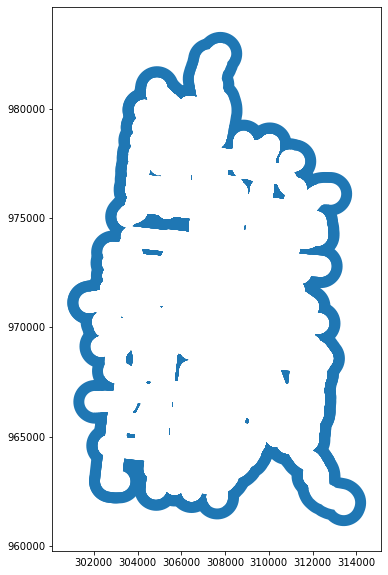

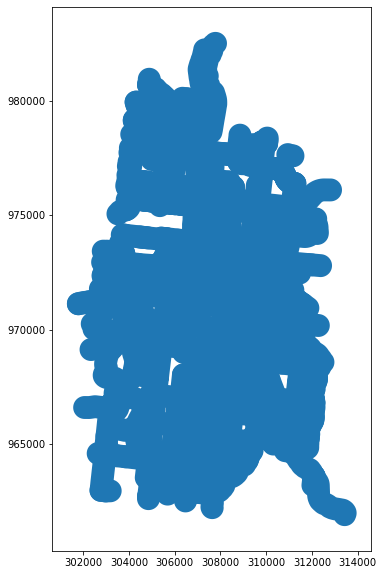

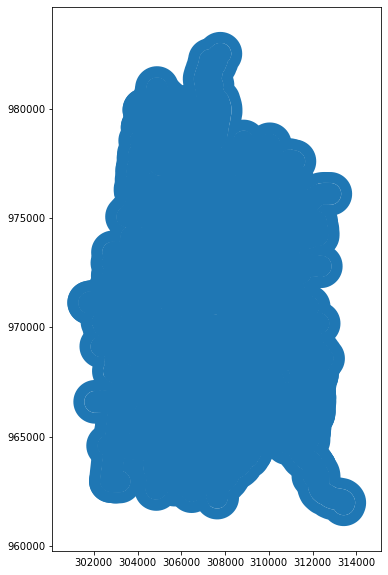

In [13]:
bikepaths_df2 = gpd.GeoDataFrame(bikepaths.buffer(500), geometry = bikepaths.buffer(500))
bikepaths_df1 = gpd.GeoDataFrame(bikepaths.buffer(1000), geometry = bikepaths.buffer(1000))

bikepaths2 = bikepaths_df2
bikepaths2['weight'] = 2

bikepaths1 = gpd.overlay(bikepaths_df1, bikepaths_df2, how='difference')
bikepaths1['weight'] = 1

bikepaths1.plot(figsize = (10,10))
bikepaths2.plot(figsize = (10,10))

bikepaths_w = gpd.overlay(bikepaths1, bikepaths2, how='union')

bikepaths_w.plot(figsize = (10,10))

bikepaths_w['weights'] = pd.concat([bikepaths_w['weight_1'].fillna(0).astype('int'), 
                                 bikepaths_w['weight_2'].fillna(0).astype('int')], axis = 1).max(axis=1)

bikepaths_w

## Intersect and sum values to find the highest value locations

In [14]:

res_union1 = gpd.overlay(bikepaths_w, coffee_shops_buffer, how='difference')

res_union = gpd.overlay(res_union1[res_union1.geometry.type=='Polygon'], cinema_w, how='intersection')

# sum up the weights
res_union['final_weights'] = res_union['weights_1'].fillna(0).astype('int') + res_union['weights_2'].fillna(0).astype('int')

res_union = res_union[['final_weights', 'geometry']] # keep only the final_weights and geometry columns

res_union.columns = ['weight', 'geometry'] # rename the columns 

res_union

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: `keep_geom_type=True` in overlay resulted in 2 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  This is separate from the ipykernel package so we can avoid doing imports until


weight                                           geometry
0          4  POLYGON ((310655.066 967812.975, 310667.534 96...
1          4  POLYGON ((310749.120 967565.762, 310759.894 96...
2          4  POLYGON ((310692.123 967714.014, 310698.779 96...
3          4  POLYGON ((310674.180 967762.604, 310698.779 96...
4          4  POLYGON ((310661.920 967795.114, 310667.534 96...
...      ...                                                ...
2102       5  POLYGON ((304405.166 969566.236, 304410.926 96...
2103       5  POLYGON ((304405.166 969566.236, 304410.926 96...
2104       5  POLYGON ((304405.166 969566.236, 304410.926 96...
2105       5  POLYGON ((304356.414 969411.536, 304382.455 96...
2106       5  POLYGON ((304433.688 969452.370, 304441.676 96...

[2107 rows x 2 columns]

<AxesSubplot:>

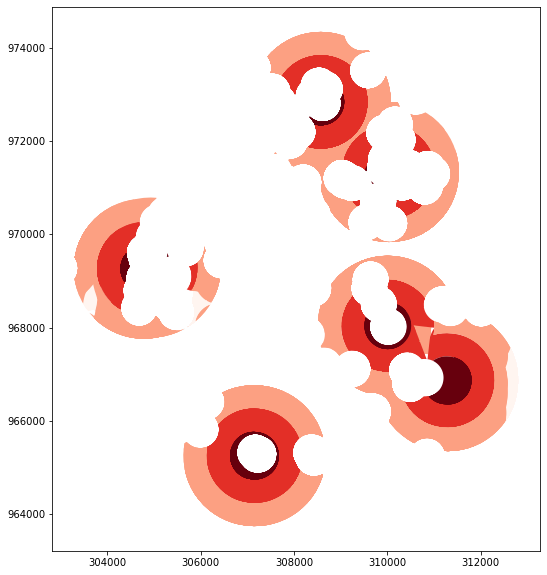

In [15]:
res_union.plot(figsize = (10,10), column = 'weight', cmap = 'Reds')


Fetch the building footprints in Minneapolis

<AxesSubplot:>

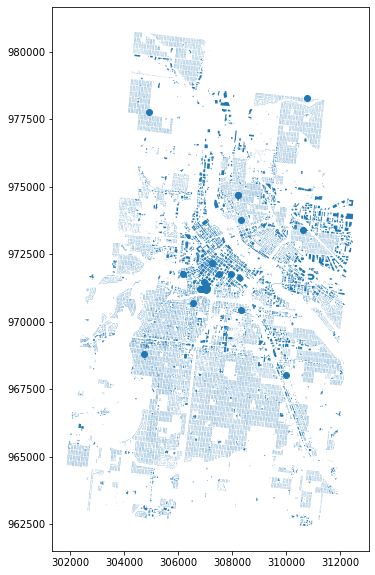

In [17]:
import warnings
warnings.filterwarnings('ignore') # Hide warnings

place = "Minneapolis, MN"
tags = {"building": True}
building = ox.geometries_from_place(place, tags)
building = building.to_crs('epsg:3174')

building.plot(figsize = (10,10))


Filtering out the candidate buildings

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: `keep_geom_type=True` in overlay resulted in 5 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  """Entry point for launching an IPython kernel.


<AxesSubplot:>

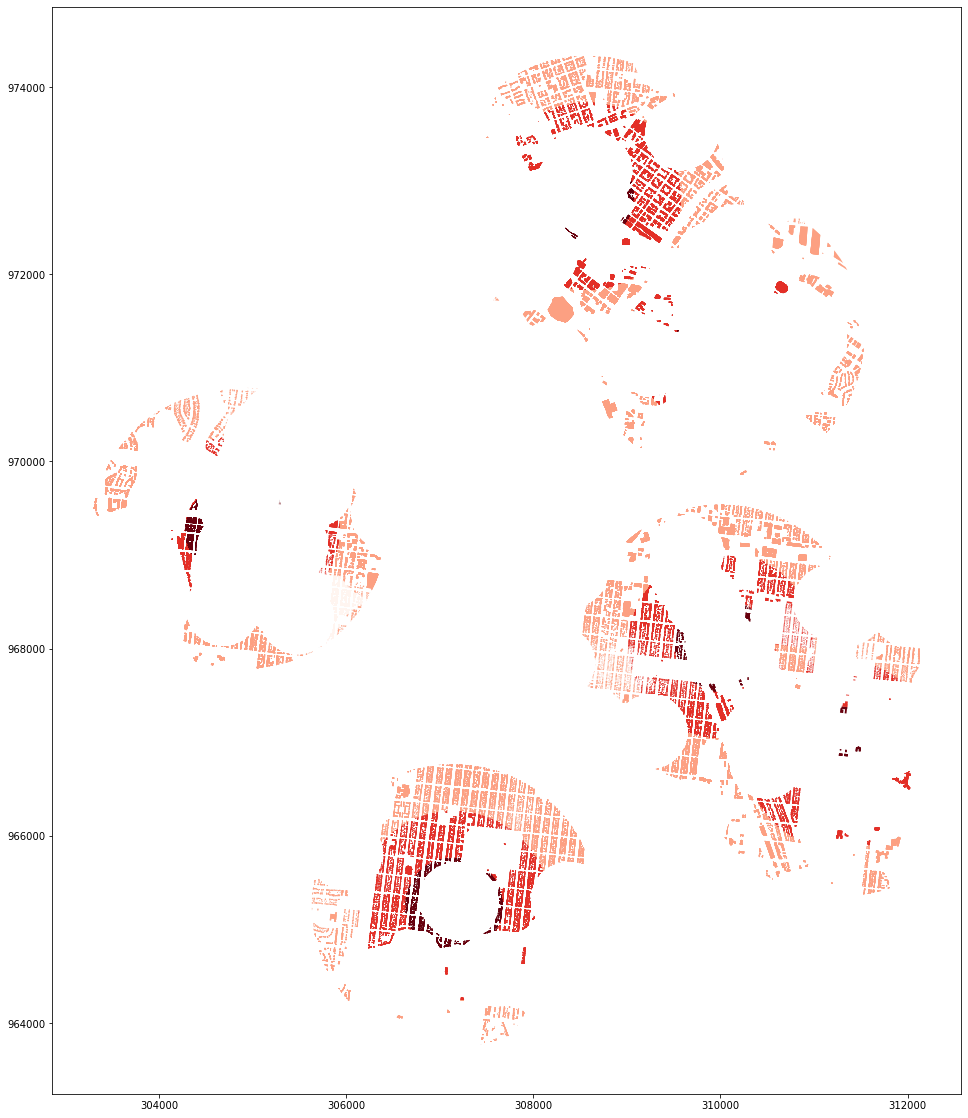

In [18]:
sites = gpd.overlay(res_union, building[building.geometry.type=='Polygon'], how='intersection')
sites.plot(figsize = (20,20), column = 'weight', cmap = 'Reds')


<AxesSubplot:>

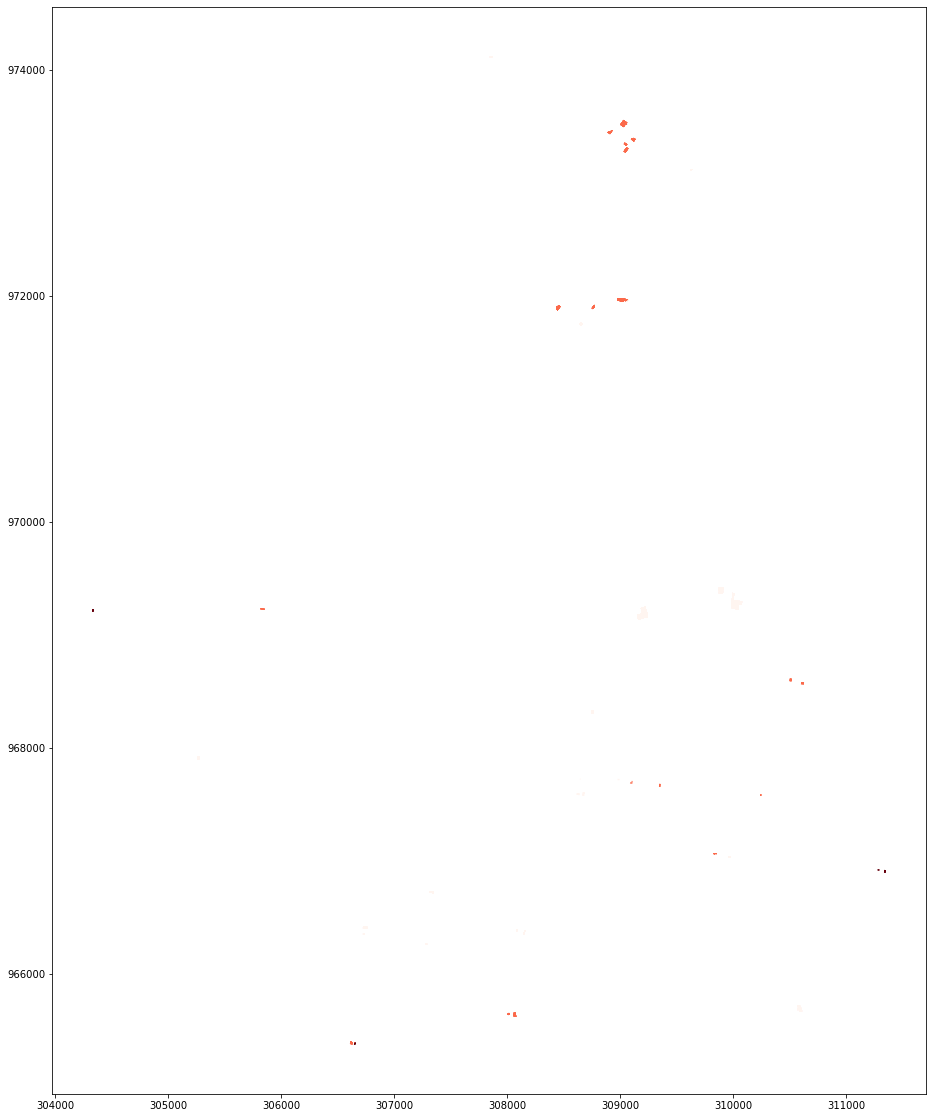

In [19]:
sites[(sites['building'] == 'commercial') | 
              (sites['building'] == 'retail') | 
              (sites['building'] == 'offices')].plot(figsize = (20,20), column = 'weight', cmap = 'Reds')


In [20]:
warnings.filterwarnings("ignore")
selected_sites = sites[(sites['building'] == 'commercial') | (sites['building'] == 'retail') | 
              (sites['building'] == 'offices')]

selected_sites['geo_area'] = selected_sites.area

selected_sites = selected_sites.to_crs(epsg='4326')
selected_sites['centroid'] = selected_sites.centroid


Visualize the final result on a folium interactive map


In [21]:
m = folium.Map(location = [44.9778, -93.2650], tiles='OpenStreetMap' , zoom_start = 13) # tiles="Stamen Toner"


for _, r in selected_sites.iterrows():

    sim_geo = gpd.GeoSeries(r['geometry']) #.simplify(tolerance=0.001) 
    geo_j = sim_geo.to_json()
    geo_j = folium.GeoJson(data=geo_j, 
                           style_function = lambda x: {'color': 'red', 'weight': 1,  'fillColor': 'YlGnBu'})
    folium.Popup(f"<i>Type: {r['building']}, Area: {r['geo_area']}</i>").add_to(geo_j)

    
    geo_j.add_to(m)
    
    folium.Marker([r['centroid'].y, r['centroid'].x], popup=f"<i>Type: {r['building']}</i>", tooltip=f"<i>Area: {r['geo_area']}</i>").add_to(m)


m

<font size="+1"><a style="background-color:blue;color:white;font-weight:bold;" 
href="./">Click here to go back to the root folder!</a></font>

